<a href="https://colab.research.google.com/github/RoaaM/time_series_price_data/blob/main/time_series_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

###(Problem #5) Time Series Prediction

In [ ]:
df = pd.read_csv('/content/prices.txt', sep=',')
df

,Date,Price
0,2/21/2017,55.478001
1,2/22/2017,54.702000
2,2/23/2017,51.198002
3,2/24/2017,51.400002
4,2/27/2017,49.245998
...,...,...
1254,02-11-22,860.000000
1255,2/14/2022,875.760010
1256,2/15/2022,922.429993
1257,2/16/2022,923.390015


In [ ]:
df = df.set_index("Date")
df.index = pd.to_datetime(df.index)

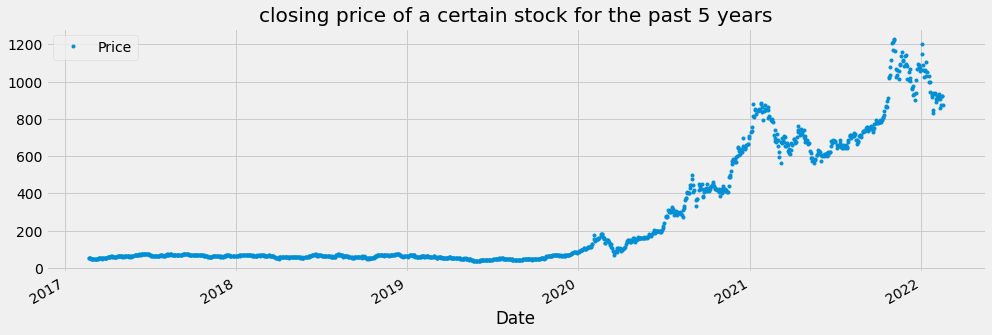

In [ ]:
df.plot(style='.', figsize=(15, 5),
        color=color_pal[0],
        title="closing price of a certain stock for the past 5 years")
plt.show()

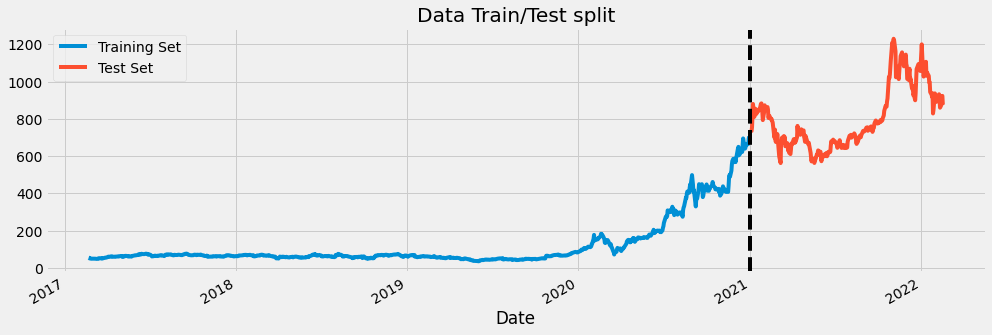

In [ ]:
train = df.loc[df.index <= '01-01-2021']
test = df.loc[df.index > '01-01-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

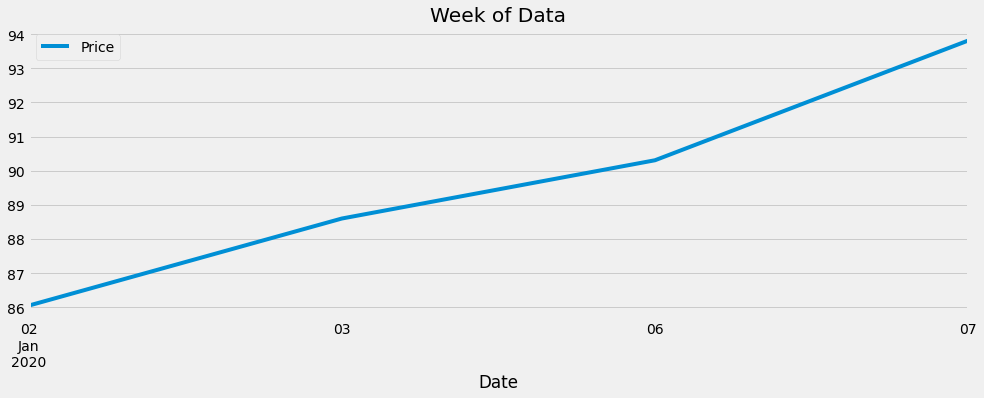

In [ ]:
df.loc[(df.index > '01-01-2020') & (df.index < '01-08-2020')].plot(figsize=(15,5), title='Week of Data')
plt.show()

In [ ]:
# Feature Creation
def create_features(df):
  """
  Create time series features based on time series index.

  """

  df = df.copy()
  df['hour'] = df.index.hour
  df['day_of_week'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['day_of_year'] = df.index.dayofyear
  df['day_of_month'] = df.index.day
  df['week_of_year'] = df.index.isocalendar().week
  return df

df = create_features(df)

In [ ]:
df

,Price,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year
Date,,,,,,,,,
2017-02-21,55.478001,0,1,1,2,2017,52,21,8
2017-02-22,54.702000,0,2,1,2,2017,53,22,8
2017-02-23,51.198002,0,3,1,2,2017,54,23,8
2017-02-24,51.400002,0,4,1,2,2017,55,24,8
2017-02-27,49.245998,0,0,1,2,2017,58,27,9
...,...,...,...,...,...,...,...,...,...
2022-02-11,860.000000,0,4,1,2,2022,42,11,6
2022-02-14,875.760010,0,0,1,2,2022,45,14,7
2022-02-15,922.429993,0,1,1,2,2022,46,15,7


In [ ]:
df.hour.unique()

array([0])

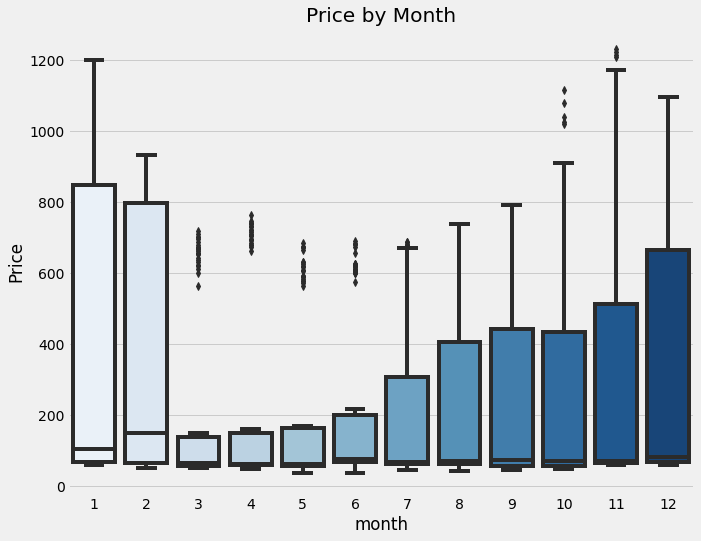

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='Price', palette='Blues')
ax.set_title('Price by Month')
plt.show()

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['day_of_year', 'hour', 'day_of_week', 'quarter', 'month', 'year']
TARGET = 'Price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[17:20:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:176.916	validation_1-rmse:815.581
[100]	validation_0-rmse:67.8164	validation_1-rmse:647.847
[200]	validation_0-rmse:27.9737	validation_1-rmse:591.335
[300]	validation_0-rmse:14.8174	validation_1-rmse:571.194
[400]	validation_0-rmse:10.8081	validation_1-rmse:563.369
[500]	validation_0-rmse:9.68524	validation_1-rmse:560.824
[600]	validation_0-rmse:9.03476	validation_1-rmse:560.106
[700]	validation_0-rmse:8.6723	validation_1-rmse:559.85
[800]	validation_0-rmse:8.41146	validation_1-rmse:559.702
[900]	validation_0-rmse:8.09932	validation_1-rmse:559.641
[999]	validation_0-rmse:7.80408	validation_1-rmse:559.6


XGBRegressor(early_stopping_rounds=50, learning_rate=0.01, n_estimators=1000)

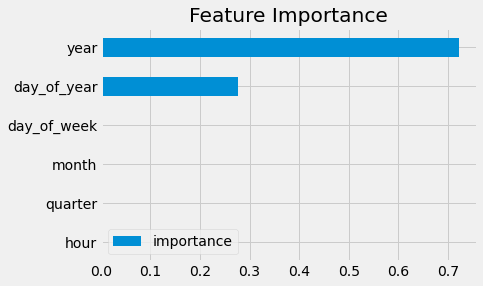

In [ ]:
# Feature Importacne
fi = pd.DataFrame(data=reg.feature_importances_,
             index=FEATURES,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
test['prediction'] = reg.predict(X_test)
test

,Price,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year,prediction
Date,,,,,,,,,,
2021-01-04,729.770020,0,0,1,1,2021,4,4,1,93.655098
2021-01-05,735.109985,0,1,1,1,2021,5,5,1,93.655098
2021-01-06,755.979980,0,2,1,1,2021,6,6,1,93.566208
2021-01-07,816.039978,0,3,1,1,2021,7,7,1,99.791931
2021-01-08,880.020020,0,4,1,1,2021,8,8,1,101.741142
...,...,...,...,...,...,...,...,...,...,...
2022-02-11,860.000000,0,4,1,2,2022,42,11,6,149.534439
2022-02-14,875.760010,0,0,1,2,2022,45,14,7,149.889694
2022-02-15,922.429993,0,1,1,2,2022,46,15,7,149.889694


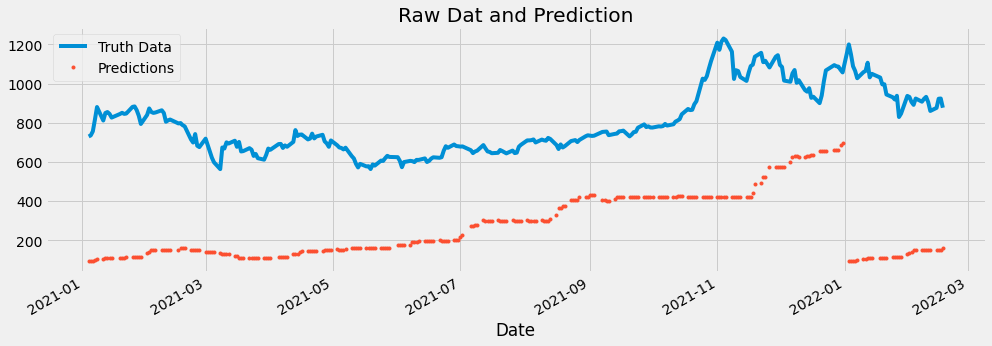

In [ ]:
# Forcast on Test
test['prediction'] = reg.predict(X_test)
ax = test[['Price']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

In [ ]:
# score (RMSE)
score = np.sqrt(mean_squared_error(test['Price'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 559.60


In [ ]:
# calculate Error
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2022-01-03    1106.124931
2022-01-04    1055.934868
2022-01-12     999.290802
2022-01-05     994.553787
2022-01-06     971.133743
2022-01-11     959.828926
2022-01-10     956.000671
2022-01-14     942.970108
2022-01-07     927.457321
2022-01-13     924.630890
Name: error, dtype: float64